In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import hdbscan

In [ ]:
train_df = pd.read_csv('../dataset/dataset_metadata/train_set.csv')
test_df = pd.read_csv('../dataset/dataset_metadata/test_set.csv')

train_embeddings = torch.load("../dataset/img_embeddings/train_img_embeddings.pt")
test_embeddings = torch.load("../dataset/img_embeddings/test_img_embeddings.pt")

train_categories = train_df['disease_type']
test_categories = test_df['disease_type']

In [7]:
tsne = TSNE(n_components=2, random_state=0)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

scaler = StandardScaler()
train_embeddings_2d_scaled = scaler.fit_transform(train_embeddings_2d)

clusterer = hdbscan.HDBSCAN(min_samples=20, min_cluster_size=50)
hdbscan_labels = clusterer.fit_predict(train_embeddings_2d_scaled)

unique_labels = np.unique(hdbscan_labels)
noise_points = np.sum(hdbscan_labels == -1)

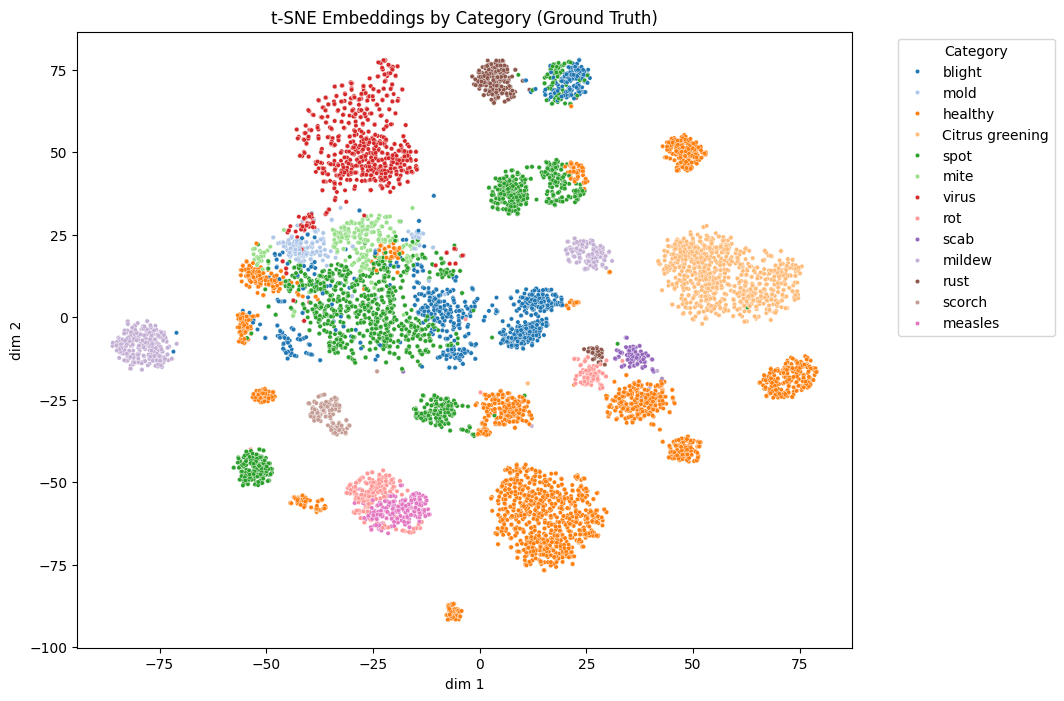

In [8]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=train_embeddings_2d[:, 0], 
    y=train_embeddings_2d[:, 1], 
    hue=train_categories, 
    palette='tab20', 
    s=10,
    legend="full"
)
plt.title('t-SNE Embeddings by Category (Ground Truth)')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../images/tsne_ground_truth.png', bbox_inches='tight')
plt.show()

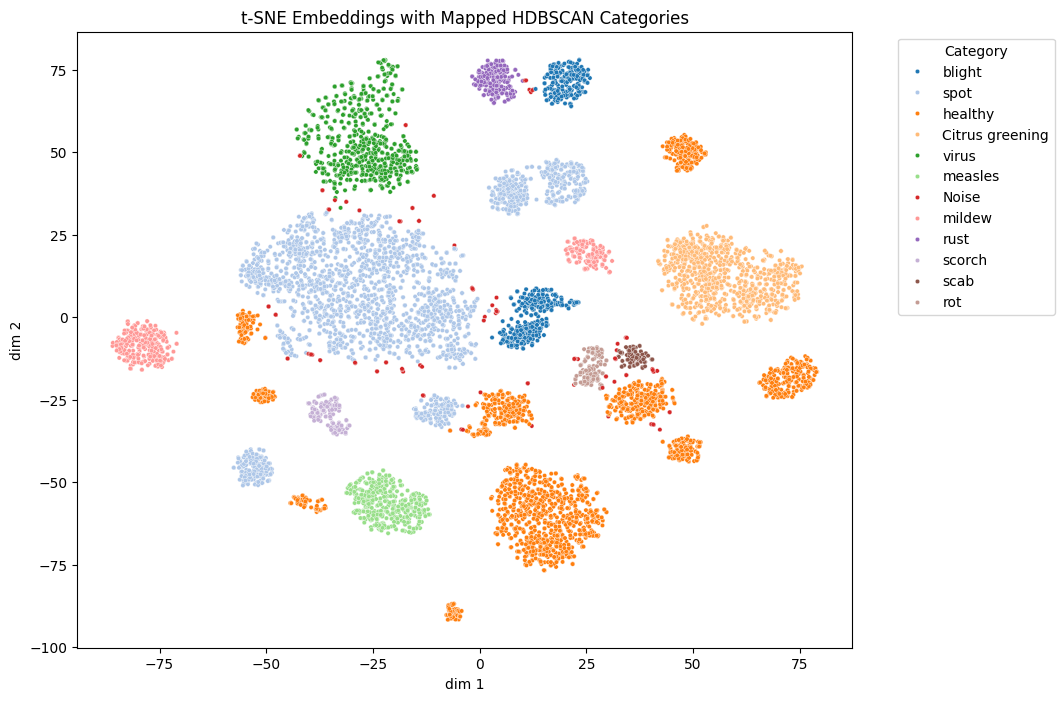

In [9]:
cluster_category_mapping = pd.DataFrame({
    'Cluster': hdbscan_labels,
    'Category': train_categories
})
cluster_to_category = (
    cluster_category_mapping[cluster_category_mapping['Cluster'] != -1]
    .groupby('Cluster')['Category']
    .agg(lambda x: x.value_counts().idxmax())
)
mapped_labels = cluster_category_mapping['Cluster'].map(cluster_to_category).fillna('Noise')
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=train_embeddings_2d[:, 0], 
    y=train_embeddings_2d[:, 1], 
    hue=mapped_labels,
    palette='tab20',
    s=10,
    legend="full"
)
plt.title('t-SNE Embeddings with Mapped HDBSCAN Categories')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('../images/tsne_hdbscan_mapped_categories.png', bbox_inches='tight')
plt.show()

### Evaluation Metrics

Silhouette Score: 0.4828
Purity: 0.8196
Adjusted Rand Index (ARI): 0.6748
Fowlkes-Mallows Index (FMI): 0.7347


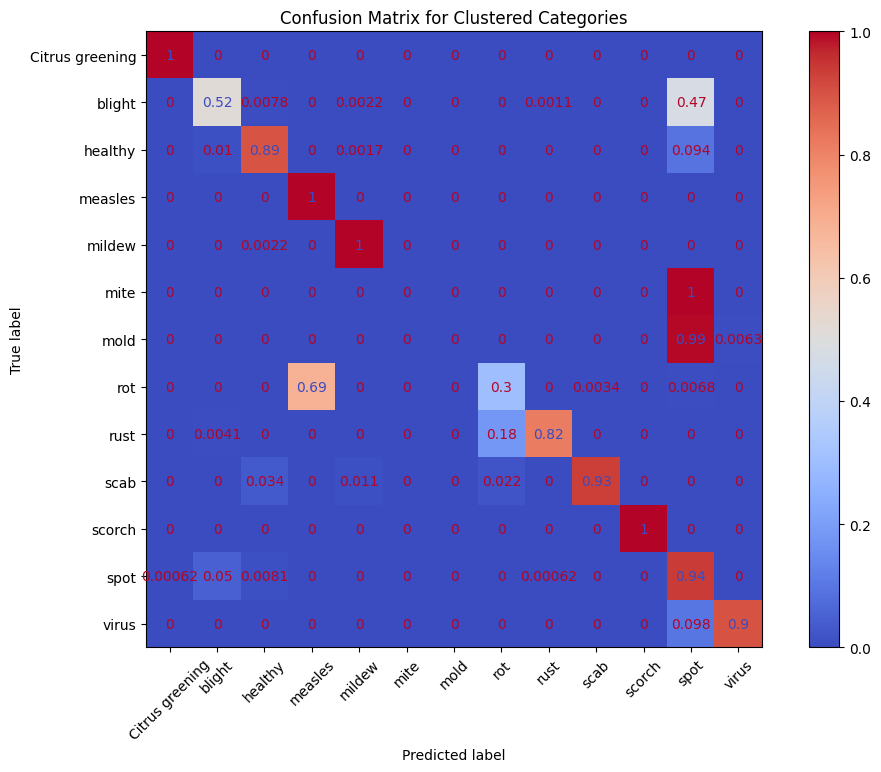

In [10]:
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score, fowlkes_mallows_score
import matplotlib.pyplot as plt

# Silhouette score measures how well data points are clustered, using intra and inter cluster distances
silhouette = silhouette_score(
    train_embeddings_2d[hdbscan_labels != -1], 
    hdbscan_labels[hdbscan_labels != -1]
)
print(f"Silhouette Score: {silhouette:.4f}")

# Purity: Percent of total data points classified correctly where the cluster category is one with max count
true_categories = cluster_category_mapping[mapped_labels != 'Noise']['Category']
majority_categories = mapped_labels[mapped_labels != 'Noise']
correct_assignments = true_categories == majority_categories
purity = correct_assignments.mean()
print(f"Purity: {purity:.4f}")

ari = adjusted_rand_score(true_categories, majority_categories)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

fmi = fowlkes_mallows_score(true_categories, majority_categories)
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_categories, majority_categories, normalize='true')

plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(train_categories))
disp.plot(cmap='coolwarm', xticks_rotation=45, ax=plt.gca())
plt.title('Confusion Matrix for Clustered Categories')
plt.savefig('../images/confusion_matrix_tsne.png')
plt.show()
